# Laboratorio No. 4
- Ricardo Méndez 21289
- Sara Echeverría 21371
- Francisco Castillo 21562
- Melissa Pérez 21385

Enlace al repositorio: [https://github.com/bl33h/bankCustomerSegmentation]

# Task 1

### ¿Qué son los grafos computacionales? y ¿cuál es su importancia para el cálculo de gradientes en aplicaciones como backpropagation?
Los grafos computacionales son una representación visual y matemática donde sus nodos corresponden a una operación y los arcos los valores de entrada/salida. Se usan comúnmente para descibir algoritmos y modelos de aprendizaje automático. En el cálculo de gradientes toman un papel importante porque proporcionan una representación clara y estructurada de las operaciones. Lo cual ayuda a que las conexiones entre nodos representen el flujo de datos entre las operaciones. Además, los grafos computacionales permiten realizar el cálculo de los gradientes de forma óptima, lo que ayuda a entrenar modelos por medio de algoritmos.

[Understanding Gradient Descent and Backpropagation](https://www.shramos.com/2019/02/understanding-gradient-descent-and_3.html)

### Detalle cuales son los componentes y pasos que conforman una red neuronal. Con esto en mente, ¿cómo mejoraría el perceptrón que hizo en el laboratorio pasado?

### ¿Cómo se selecciona el valor K usando el método de la silueta para el algoritmo de K-Means. Explique las fórmulas (ecuaciones) que lo componen así como las asumpciones, si hay.

### Investigue sobre Principal Component Analysis (PCA) y responda respecto a algoritmos como K-Means ¿Cómo podría ayudarle a mejorar la calidad de sus clusters cuando se usa K-Means?

# Análisis exploratorio

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

plt.style.use('ggplot')

In [2]:
df = pd.read_csv('data/bank_transactions.csv')
df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1048567 non-null  object 
 1   CustomerID               1048567 non-null  object 
 2   CustomerDOB              1045170 non-null  object 
 3   CustGender               1047467 non-null  object 
 4   CustLocation             1048416 non-null  object 
 5   CustAccountBalance       1046198 non-null  float64
 6   TransactionDate          1048567 non-null  object 
 7   TransactionTime          1048567 non-null  int64  
 8   TransactionAmount (INR)  1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB
None


In [4]:
print(df.describe())

       CustAccountBalance  TransactionTime  TransactionAmount (INR)
count        1.046198e+06     1.048567e+06             1.048567e+06
mean         1.154035e+05     1.570875e+05             1.574335e+03
std          8.464854e+05     5.126185e+04             6.574743e+03
min          0.000000e+00     0.000000e+00             0.000000e+00
25%          4.721760e+03     1.240300e+05             1.610000e+02
50%          1.679218e+04     1.642260e+05             4.590300e+02
75%          5.765736e+04     2.000100e+05             1.200000e+03
max          1.150355e+08     2.359590e+05             1.560035e+06


In [5]:
# relevant columns in the dataframe
selected_features = [
    'CustomerDOB',  # To get the age of the customer
    'CustGender',  # To get the gender
    'CustAccountBalance',  # To get the account balance
    'TransactionAmount (INR)',  # To get the amount of the transaction in rupees
]

features = df[selected_features]

In [6]:
# check for missing values
features.isnull().sum()

CustomerDOB                3397
CustGender                 1100
CustAccountBalance         2369
TransactionAmount (INR)       0
dtype: int64

In [7]:
# Remove missing values
features = features.dropna()

In [8]:
features.count()

CustomerDOB                1041765
CustGender                 1041765
CustAccountBalance         1041765
TransactionAmount (INR)    1041765
dtype: int64

### Encoding y transformación de valores

In [9]:
# categorical features and change other values to its numerical representation
features['CustGender'] = features['CustGender'].map({'F': 1, 'M': 0})  # 1 for female and 0 for male

# rename column
features.rename(
    columns={
        'CustGender': 'Female?',
        'CustAccountBalance': 'Balance',
        'TransactionAmount (INR)': 'Amount',
    },
    inplace=True)

In [10]:
features = features.dropna()
features.count()

CustomerDOB    1041764
Female?        1041764
Balance        1041764
Amount         1041764
dtype: int64

In [11]:
features["CustomerDOB"] = pd.to_datetime(features["CustomerDOB"])

C:\Users\casti\AppData\Local\Temp\ipykernel_6300\297486681.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  features["CustomerDOB"] = pd.to_datetime(features["CustomerDOB"])


In [12]:
# Get the Customer age
features = features.drop(features[features['CustomerDOB'] == '1/1/1800'].index, axis=0)
features.loc[features.CustomerDOB.dt.year >= 2022, 'CustomerDOB'] = features.loc[features.CustomerDOB.dt.year >= 2022, 'CustomerDOB'] - pd.DateOffset(years=100)
features['CustomerAge'] = ((pd.to_datetime('today') - features['CustomerDOB']).dt.days / 365.25).round(0)

In [13]:
features.head()

,CustomerDOB,Female?,Balance,Amount,CustomerAge
0,1994-10-01,1.0,17819.05,25.0,29.0
1,1957-04-04,0.0,2270.69,27999.0,67.0
2,1996-11-26,1.0,17874.44,459.0,27.0
3,1973-09-14,1.0,866503.21,2060.0,50.0
4,1988-03-24,1.0,6714.43,1762.5,36.0


In [14]:
# Drop NaN values
features = features.dropna()

# Drop the CustomerDOB column
features = features.drop('CustomerDOB', axis=1)

In [15]:
features.head()

,Female?,Balance,Amount,CustomerAge
0,1.0,17819.05,25.0,29.0
1,0.0,2270.69,27999.0,67.0
2,1.0,17874.44,459.0,27.0
3,1.0,866503.21,2060.0,50.0
4,1.0,6714.43,1762.5,36.0


In [16]:
features.describe()

,Female?,Balance,Amount,CustomerAge
count,985473.000000,9.854730e+05,9.854730e+05,985473.000000
mean,0.276922,1.060590e+05,1.452449e+03,38.649695
std,0.447478,8.178443e+05,6.139422e+03,8.763175
min,0.000000,0.000000e+00,0.000000e+00,3.000000
25%,0.000000,4.581130e+03,1.510000e+02,33.000000
50%,0.000000,1.600759e+04,4.310000e+02,36.000000
75%,1.000000,5.375908e+04,1.125000e+03,42.000000
max,1.000000,1.150355e+08,1.560035e+06,101.000000


### Balanceo de clases

En este caso la variable de interés 'CustGender' sí está desbalanceada, por lo que es pertinente aplicar una técnica para corregirlo.

In [17]:
features['Female?'].value_counts()

Female?
0.0    712574
1.0    272899
Name: count, dtype: int64

In [18]:
male = features[features['Female?'] == 0]
female = features[features['Female?'] == 1]
male = male.sample(n=len(female), random_state=7)
features = pd.concat([male, female])

In [19]:
features['Female?'].value_counts()

Female?
0.0    272899
1.0    272899
Name: count, dtype: int64

### Scaling
Las magnitudes de los datos varían significativamente, por lo que es necesario escalar los valores de 'TransactionTimeSeconds' y 'TransactionAmount (INR)'.

In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [21]:
# Create a copy of the dataframe with scaled features (for it to be used for clustering, classify, then analyze the data with the original features)
scaled_features = features.copy()

# Scale the features
to_scale = ['Amount', 'CustomerAge', 'Balance']

# Scale the features
scaled_features[to_scale] = scaler.fit_transform(scaled_features[to_scale])

# Show the scaled features
scaled_features.head()

,Female?,Balance,Amount,CustomerAge
974270,0.0,-0.107183,-0.238270,0.169863
622443,0.0,-0.113533,-0.179216,0.509318
4768,0.0,-0.086650,-0.135219,-0.622200
37123,0.0,-0.116716,0.118060,0.509318
185587,0.0,-0.127482,-0.127022,0.283014


### Feature selection
Debido a la naturaleza del objetivo para este dataframe, el cual es segmentar a clientes de una entidad bancaria para poder así tomar decisiones a nivel comercial y
potenciar las operaciones de la empresa. Los features considerados de utilidad son:
- 'Female?': para identificar el género del cliente (1 para mujer, 0 para hombre)
- 'Amount': para identificar el monto de la transacción realizada por el cliente
- 'CustomerAge': para identificar la edad del cliente
- 'Balance': para identificar el valor de la cuenta del cliente

En términos generales, las variables del dataframe no se encontraban en óptimas condiciones para la implementación del modelo no supervisado, por lo que se realizaron acciones como encoding, scaling y balanceo de clases. Los features expuestos anteriormente representan temas de interés para una entidad bancaria, ya que con estos es posible la identificación de grupos de clientela, permitiendo la visualización de alguna correlación entre el género, el monto de las transacciones realizadas por el cliente, el valor de la cuenta, entre otros. Por dicha razón, se seleccionaron los features indicadas.

# Task 2.1 K-Means

## ¿Es necesario hacer un split del dataset? ¿Por qué?
No, el objetivo de hacer un split de los datos es el poder evaluar el desempeño del modelo. Al ser no supervisado, el hacer esto puede ser contraproducente, ya que no se cuenta con un target para evaluar el desempeño del modelo. Por lo que se puede utilizar el dataset completo para el entrenamiento del modelo.

## Selección del número de clusters

In [22]:
from sklearn.cluster import KMeans

In [23]:
# List to save the inertia for each number of clusters
inertia_values = []

# Range of cluster numbers to check
cluster_range = range(2, 11)

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=7)
    kmeans.fit(scaled_features)
    inertia_values.append(kmeans.inertia_)

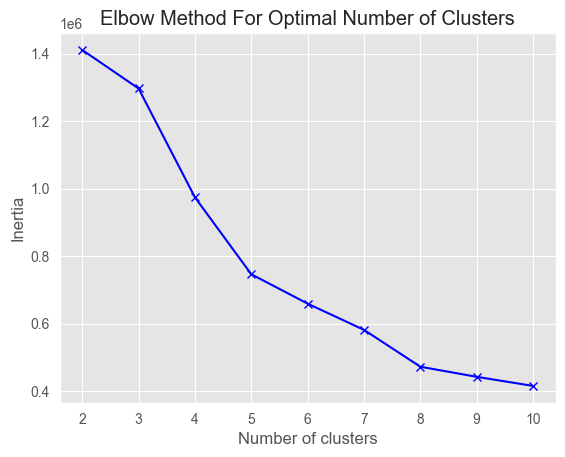

In [24]:
# Plotting the inertia values
plt.plot(cluster_range, inertia_values, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.show()

El número ideal de clusters es de 5.

## Modelo sin Librerías

In [25]:
def get_euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))


class KMeansScratch:
    # Reference: https://www.youtube.com/watch?v=6UF5Ysk_2gk
    def __init__(self, K=5, max_iterations=100):
        self.K = K
        self.max_iterations = max_iterations

        # Each list contains the samples indices for the respective cluster
        self.clusters = [[] for _ in range(self.K)]

        # the centers (mean feature vector) for each cluster
        self.centroids = []

    def predict(self, X: pd.DataFrame):
        self.X = X
        self.n_samples, self.n_features = X.shape

        # Get random samples to be the initial centroids
        random_samples_ids = np.random.choice(self.n_samples, self.K, replace=False)
        self.centroids = [self.X.iloc[id] for id in random_samples_ids]

        # Optimize clusters
        for _ in range(self.max_iterations):
            # Assign samples to the closest centroids to create clusters
            self.clusters = self._create_clusters(self.centroids)

            # Calculate new centroids from the clusters
            old_centroids = self.centroids
            self.centroids = self._get_centroids(self.clusters)

            # Check if clusters have changed
            if self._has_converged(old_centroids, self.centroids):
                break

        # Classify samples as the index of their clusters
        return self._get_cluster_labels(self.clusters)

    def _create_clusters(self, centroids: list):
        clusters = [[] for _ in range(self.K)]

        for id, sample in enumerate(self.X.values):
            # Get the closest centroid for the sample
            centroid_id = self._closest_centroid(sample, centroids)
            clusters[centroid_id].append(id)

        return clusters

    def _closest_centroid(self, sample, centroids):
        distances = [get_euclidean_distance(sample, point) for point in centroids]
        closest_id = np.argmin(distances)

        return closest_id

    def _get_centroids(self, clusters: list):
        centroids = np.zeros((self.K, self.n_features))
        for cluster_id, cluster in enumerate(clusters):
            cluster_mean = np.mean(self.X.iloc[cluster], axis=0)
            centroids[cluster_id] = cluster_mean
        return centroids

    def _has_converged(self, old_centroids: list, centroids: list):
        distances = [get_euclidean_distance(old_centroids[i], centroids[i]) for i in range(self.K)]
        return sum(distances) == 0

    def _get_cluster_labels(self, clusters: list):
        labels = np.empty(self.n_samples)

        for cluster_id, cluster in enumerate(clusters):
            for sample_id in cluster:
                labels[sample_id] = cluster_id

        return labels


In [26]:
kmeans_scratch = KMeansScratch()

predicted_clusters = kmeans_scratch.predict(scaled_features)

### Visualización de los Clusters generados

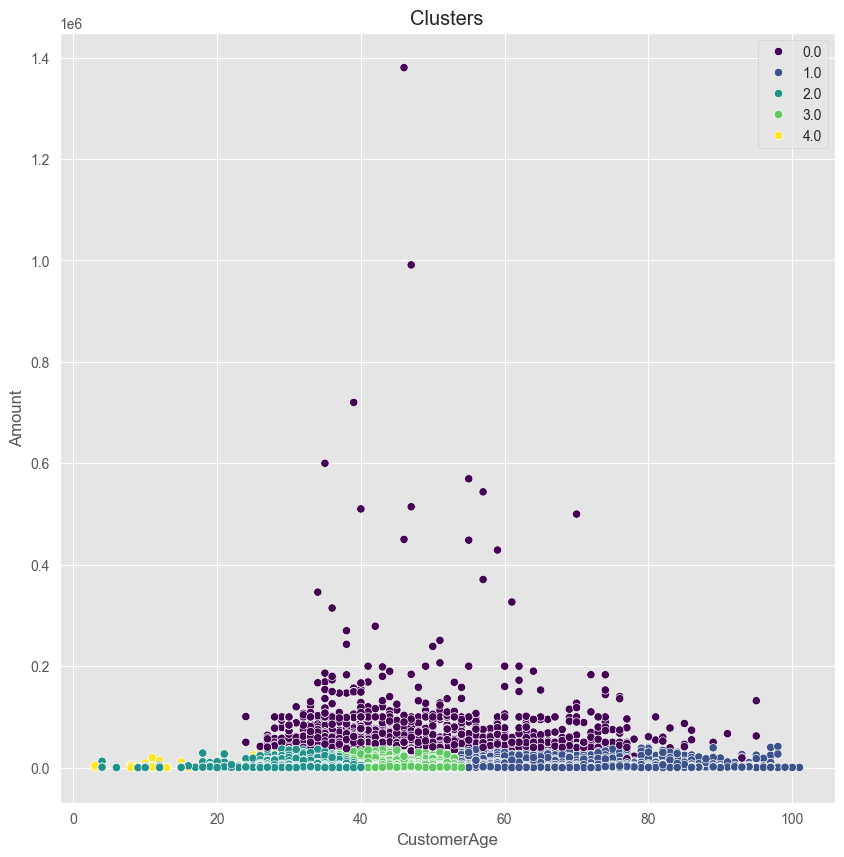

In [27]:
# Plot the clusters
plt.figure(figsize=(10, 10))
sns.scatterplot(x='CustomerAge', y='Amount', data=features, hue=predicted_clusters, palette='viridis')
plt.title('Clusters')
plt.show()

### Evaluación del modelo

In [28]:
# Silhouette score
from sklearn.metrics import silhouette_score

silhouette_score(scaled_features, predicted_clusters)

0.42020012819989727

El modelo tiene un silhouette score de 0.42, lo que indica que los clusters están parcialmente definidos; parcialmente debido a que, cómo puede observarse en la parte superior, la distribución de los datos no permite que los clusters sean tan precisos. Sin embargo, nos da una idea de como pueden estar agrupados los clientes. Esta métrica fue seleccionada, ya que es una medida de cuán similar es un punto a su propio cluster (cohesión) en comparación con otros clusters (separación). El valor de la métrica es entre -1 y 1, donde un valor cercano a 1 indica que el punto está bien clasificado.

# Task 2.2 Mixture Models